## Medicaid Preventive Care Outreach Optimization (HEDIS + SDOH Analytics)

### Summary: 

#### This project simulates a payer-side outreach analytics workflow, mirroring the data extracted from a provider organization through the HEDIS outcomes. The goal is to identify care gaps, integrate some HEDIS quality measures and Social Determinants of Health (SDOH), and prioritize patients who can be targeted for outreach purposes. 

#### The project uses synthetic datasets modeled by ChatGPT using Python to generate the tables with random information, including claims encounters, conditions, enrollment, HEDIS gaps, medicaid members, attribution, pharmacy, CDC equity health rates, providers, and utilization. 

#### As a result, patients were assigned a score to count the HEDIS gaps, risk score, chronic condition burden, and lastly, the patients were divided into main outcomes: reached and unreached.  

#### The final outputs include member stratification (High / Medium / Low priority), care gap summaries, and explainable analytics to support outreach and care coordination teams.

### Business Problem and Use Case

#### Health plans face limited resources when attempting to close preventive care gaps across vulnerable populations, including Medicaid patients. On the other hand, connecting the patient with Wellness programs, education, and resources can help to decrease the economic burden, poor quality of life, and deterioration of health conditions, among other consequences. Without data-driven prioritization, outreach efforts may fail to reach patients with different levels of prioritization. This project addresses this challenge by developing an explainable analytics framework that helps outreach teams identify which members to contact first, why they are prioritized, and which care gaps to target.

### Data sources & tables

#### > Members → demographics & geography

#### > Enrollment → Medicaid eligibility & continuity

#### > Claims_encounters → diagnoses, utilization, paid amounts

#### > Conditions → chronic condition flags (diabetes, hypertension, etc.)

#### > Labs → HbA1c, LDL, eGFR, UACR

#### > Pharmacy → medication fills & adherence proxies

#### > Hedis_gaps → open preventive care gaps

#### > Outreach_contacts → outreach attempts and outcomes

#### > CDC_places → area-level SDOH indicators

### Agenda: 

#### 1. Import Libraries
#### 2. Import all tables
#### 3. Get information from each table, explore columns, count, and data type. 
#### 4. Univariate analysis: explore the distribution of each table, N, and %
#### 5. Graphs: plot provider level distribution using bar/barh graphs
#### 6. Merging all the datasets in one: df_final
#### 7. Bivariate analysis: 
#### 8. Identifying the non-completed gap population
#### 9. CDC and HEDIS analysis: statistical tests (t-test & chi-square)  






#### 1. Import libraries 

In [1]:
## libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

####  2. Import all tables ##

In [2]:
### import all the tables

member_atribution = (r'/kaggle/input/synthetic-data/member_attribution.csv')
df_members = pd.read_csv(member_atribution)

enrollment = (r'/kaggle/input/synthetic-data/enrollment.csv')
df_enrollment = pd.read_csv(enrollment)

labs = (r'/kaggle/input/synthetic-data/labs.csv')
df_labs = pd.read_csv(labs)

claims_encounters = (r'/kaggle/input/synthetic-data/claims_encounters.csv')
df_claims_encounters = pd.read_csv(claims_encounters)

outreach_contacts = (r'/kaggle/input/synthetic-data/outreach_contacts.csv')
df_outreach_contacts = pd.read_csv(outreach_contacts)

pharmacy = (r'/kaggle/input/synthetic-data/pharmacy.csv')
df_pharmacy = pd.read_csv(pharmacy)

providers = (r'/kaggle/input/synthetic-data/providers.csv')
df_providers = pd.read_csv(providers)

medicaid_members = (r'/kaggle/input/synthetic-data/medicaid_members.csv')
df_medicaid_members = pd.read_csv(medicaid_members)
df_medicaid_members['age_group'] = pd.cut(df_medicaid_members['age'],bins=[0, 18, 30, 45, 60, 75, 100],
    right=False
)

cdc_places = (r'/kaggle/input/synthetic-data/places_zcta_expanded.csv')
df_cdc_places = pd.read_csv(cdc_places)

conditions = (r'/kaggle/input/synthetic-data/conditions.csv')
df_conditions = pd.read_csv(conditions)

utilization = (r'/kaggle/input/synthetic-data/utilization_12m.csv')
df_utilization = pd.read_csv(utilization)

hedis_gaps = (r'/kaggle/input/synthetic-data/hedis_gaps_expanded.csv')
df_hedis_gaps = pd.read_csv(hedis_gaps)

####  3. Get info from all tables: Identify count and type of data ###

In [3]:
## get info of each table

df_labs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6477 entries, 0 to 6476
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lab_id        6477 non-null   int64  
 1   member_id     6477 non-null   int64  
 2   result_date   6477 non-null   object 
 3   test_code     6477 non-null   object 
 4   test_name     6477 non-null   object 
 5   result_value  6477 non-null   float64
 6   unit          6477 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 354.3+ KB


In [4]:
## potential graph: risk score vs result_value 

df_enrollment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   member_id                 5000 non-null   int64 
 1   enrollment_start_date     5000 non-null   object
 2   enrollment_end_date       5000 non-null   object
 3   coverage_continuous_flag  5000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 156.4+ KB


In [5]:
df_members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   member_id                5000 non-null   int64  
 1   pcp_provider_id          4117 non-null   float64
 2   care_team_specialist_id  1754 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 117.3 KB


In [6]:
icd10_map = {
    "Z00.00": "General adult medical, no findings",
    "J06.9": "Acute upper respiratory infection, unspecified",
    "M54.5": "Low back pain",
    "R53.83": "Other fatigue",
    "I10": "Essential (primary) hypertension",
    "E11.9": "Type 2 diabetes mellitus without complications",
    "E11.65": "Type 2 diabetes mellitus with hyperglycemia",
    "F33.1": "Major depressive disorder, recurrent, moderate",
    "F32.9": "Major depressive disorder, single episode, unspecified",
    "J44.9": "Chronic obstructive pulmonary disease, unspecified",
    "N18.3": "Chronic kidney disease, stage 3 (moderate)",
    "N18.4": "Chronic kidney disease, stage 4 (severe)"
}

df_claims_encounters["diagnosis_name"] = (
    df_claims_encounters["diagnosis_code"]
    .map(icd10_map)
    .fillna("Other / Unmapped diagnosis")
)


df_claims_encounters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43235 entries, 0 to 43234
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   claim_id          43235 non-null  int64  
 1   member_id         43235 non-null  int64  
 2   service_date      43235 non-null  object 
 3   encounter_type    43235 non-null  object 
 4   place_of_service  43235 non-null  int64  
 5   procedure_code    43235 non-null  object 
 6   diagnosis_code    43235 non-null  object 
 7   provider_id       43235 non-null  int64  
 8   paid_amount       43235 non-null  float64
 9   diagnosis_name    43235 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 3.3+ MB


In [7]:
df_outreach_contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12944 entries, 0 to 12943
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   contact_id      12944 non-null  int64 
 1   member_id       12944 non-null  int64 
 2   measure_id      12944 non-null  object
 3   contact_date    12944 non-null  object
 4   channel         12944 non-null  object
 5   outcome         12944 non-null  object
 6   attempt_number  12944 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 708.0+ KB


In [8]:
df_pharmacy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28276 entries, 0 to 28275
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rx_id        28276 non-null  int64  
 1   member_id    28276 non-null  int64  
 2   fill_date    28276 non-null  object 
 3   ndc_code     28276 non-null  object 
 4   drug_name    28276 non-null  object 
 5   drug_class   28276 non-null  object 
 6   days_supply  28276 non-null  int64  
 7   quantity     28276 non-null  int64  
 8   paid_amount  28276 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 1.9+ MB


In [9]:
df_providers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   provider_id         200 non-null    int64 
 1   provider_specialty  200 non-null    object
 2   provider_npi_sim    200 non-null    int64 
 3   provider_zip        200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [10]:
print(df_medicaid_members.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   member_id           5000 non-null   int64   
 1   age                 5000 non-null   int64   
 2   sex                 5000 non-null   object  
 3   zip                 5000 non-null   int64   
 4   zip3                5000 non-null   int64   
 5   plan_type           5000 non-null   object  
 6   dual_eligible_flag  5000 non-null   int64   
 7   preferred_language  5000 non-null   object  
 8   has_pcp_flag        5000 non-null   int64   
 9   enrollment_months   5000 non-null   int64   
 10  age_group           5000 non-null   category
dtypes: category(1), int64(7), object(3)
memory usage: 395.9+ KB
None


In [11]:
df_cdc_places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   zip                            50 non-null     int64  
 1   poverty_rate                   50 non-null     float64
 2   education_lte_highschool_rate  50 non-null     float64
 3   language_isolation_rate        50 non-null     float64
 4   broadband_access_rate          50 non-null     float64
 5   no_routine_checkup_rate        50 non-null     float64
 6   cost_barrier_care_rate         50 non-null     float64
 7   diabetes_prevalence            50 non-null     float64
 8   hypertension_prevalence        50 non-null     float64
 9   smoking_prevalence             50 non-null     float64
 10  physical_inactivity_rate       50 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 4.4 KB


In [12]:
df_conditions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   member_id             5000 non-null   int64
 1   diabetes_flag         5000 non-null   int64
 2   hypertension_flag     5000 non-null   int64
 3   copd_flag             5000 non-null   int64
 4   depression_flag       5000 non-null   int64
 5   ckd_flag              5000 non-null   int64
 6   obesity_flag          5000 non-null   int64
 7   multimorbidity_count  5000 non-null   int64
dtypes: int64(8)
memory usage: 312.6 KB


In [13]:
df_utilization.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   member_id               5000 non-null   int64
 1   pcp_visits_12m          5000 non-null   int64
 2   specialist_visits_12m   5000 non-null   int64
 3   ed_visits_12m           5000 non-null   int64
 4   inpatient_admits_12m    5000 non-null   int64
 5   urgent_care_visits_12m  5000 non-null   int64
 6   total_claims_12m        5000 non-null   int64
 7   last_pcp_visit_days     5000 non-null   int64
dtypes: int64(8)
memory usage: 312.6 KB


In [14]:
## adding risk score and risk score group in hedis table

df_hedis_gaps["risk_score"] = (
                              df_conditions['diabetes_flag'] +
                              df_conditions['hypertension_flag'] +
                              df_conditions['copd_flag'] +
                              df_conditions['depression_flag'] +
                              df_conditions['ckd_flag'] +
                              df_conditions['obesity_flag'] +
                              df_conditions['multimorbidity_count']
                              )


df_hedis_gaps["risk_score_group"] = pd.cut(
    df_hedis_gaps["risk_score"],
    bins=[-1, 1, 3, 7],
    labels=["Low", "Medium", "High"]
)



df_hedis_gaps.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   member_id          50000 non-null  int64   
 1   measure_id         50000 non-null  object  
 2   measure_name       50000 non-null  object  
 3   eligible_flag      50000 non-null  int64   
 4   gap_open_flag      50000 non-null  int64   
 5   last_service_date  18667 non-null  object  
 6   due_by_date        30225 non-null  object  
 7   measure_weight     50000 non-null  int64   
 8   risk_score         5000 non-null   float64 
 9   risk_score_group   4656 non-null   category
dtypes: category(1), float64(1), int64(4), object(4)
memory usage: 3.5+ MB


#### 4. Univariate analysis: 

In [15]:
## summarize tables

def summarize_counts_pct(df, col):
    out = df[col].value_counts(dropna=False).to_frame("N")
    out["Percent"] = (out["N"] / out["N"].sum() * 100).round(1)
    return out.reset_index().rename(columns={"index": col})


summarize_counts_pct(df_enrollment, "coverage_continuous_flag")

,coverage_continuous_flag,N,Percent
0,1,4536,90.7
1,0,464,9.3


In [16]:
summarize_counts_pct(df_conditions, "multimorbidity_count")

,multimorbidity_count,N,Percent
0,1,1568,31.4
1,2,1383,27.7
2,0,911,18.2
3,3,794,15.9
4,4,292,5.8
5,5,48,1.0
6,6,4,0.1


In [17]:
summarize_counts_pct(df_conditions, "obesity_flag")

,obesity_flag,N,Percent
0,0,3316,66.3
1,1,1684,33.7


In [18]:
summarize_counts_pct(df_conditions, "ckd_flag")

,ckd_flag,N,Percent
0,0,4209,84.2
1,1,791,15.8


In [19]:
summarize_counts_pct(df_conditions, "depression_flag")

,depression_flag,N,Percent
0,0,3993,79.9
1,1,1007,20.1


In [20]:
print(summarize_counts_pct(df_conditions, "copd_flag"))

   copd_flag     N  Percent
0          0  4202     84.0
1          1   798     16.0


In [21]:
summarize_counts_pct(df_conditions, "hypertension_flag")

,hypertension_flag,N,Percent
0,0,2705,54.1
1,1,2295,45.9


In [22]:
summarize_counts_pct(df_conditions, "diabetes_flag")

,diabetes_flag,N,Percent
0,0,3427,68.5
1,1,1573,31.5


In [23]:
summarize_counts_pct(df_medicaid_members, "preferred_language")

,preferred_language,N,Percent
0,English,3060,61.2
1,Spanish,1266,25.3
2,Haitian Creole,467,9.3
3,Portuguese,207,4.1


In [24]:
summarize_counts_pct(df_medicaid_members, "sex")

,sex,N,Percent
0,F,2778,55.6
1,M,2222,44.4


In [25]:
summarize_counts_pct(df_medicaid_members, "age_group")

,age_group,N,Percent
0,"[75, 100)",1101,22.0
1,"[60, 75)",1073,21.5
2,"[45, 60)",1005,20.1
3,"[30, 45)",990,19.8
4,"[18, 30)",831,16.6
5,"[0, 18)",0,0.0


In [26]:
summarize_counts_pct(df_providers, "provider_specialty")

,provider_specialty,N,Percent
0,Primary Care,52,26.0
1,Family Medicine,29,14.5
2,Internal Medicine,26,13.0
3,Pediatrics,26,13.0
4,Endocrinology,18,9.0
5,OB/GYN,18,9.0
6,Cardiology,10,5.0
7,Pulmonology,8,4.0
8,Behavioral Health,7,3.5
9,Ophthalmology,6,3.0


In [27]:
summarize_counts_pct(df_pharmacy, "drug_class")

,drug_class,N,Percent
0,ACE Inhibitor,9718,34.4
1,Statin,7808,27.6
2,Antidiabetic,6937,24.5
3,SSRI,2246,7.9
4,Bronchodilator,1567,5.5


In [28]:
summarize_counts_pct(df_outreach_contacts, "attempt_number")

,attempt_number,N,Percent
0,1,6462,49.9
1,2,4305,33.3
2,3,2177,16.8


In [29]:
summarize_counts_pct(df_outreach_contacts, "outcome")

,outcome,N,Percent
0,No Answer,2240,17.3
1,Completed Gap,2200,17.0
2,Reached,2161,16.7
3,Scheduled,2134,16.5
4,Opted Out,2125,16.4
5,Left Voicemail,2084,16.1


In [30]:
summarize_counts_pct(df_outreach_contacts, "channel")

,channel,N,Percent
0,Email,3313,25.6
1,Phone,3308,25.6
2,SMS,3174,24.5
3,Mail,3149,24.3


In [31]:
summarize_counts_pct(df_claims_encounters, "encounter_type")

,encounter_type,N,Percent
0,PCP,17937,41.5
1,Specialist,11342,26.2
2,ED,6924,16.0
3,Urgent Care,5682,13.1
4,Inpatient,1350,3.1


In [32]:
summarize_counts_pct(df_claims_encounters, "diagnosis_name")

,diagnosis_name,N,Percent
0,"General adult medical, no findings",7131,16.5
1,"Acute upper respiratory infection, unspecified",7095,16.4
2,Low back pain,7066,16.3
3,Other fatigue,7040,16.3
4,Essential (primary) hypertension,3632,8.4
5,Type 2 diabetes mellitus without complications,2302,5.3
6,Type 2 diabetes mellitus with hyperglycemia,2300,5.3
7,"Major depressive disorder, recurrent, moderate",1442,3.3
8,"Major depressive disorder, single episode, uns...",1422,3.3
9,"Chronic obstructive pulmonary disease, unspeci...",1367,3.2


#### 5. Exploratory Data Analysis: plot provider level distribution using bar/barh graphs

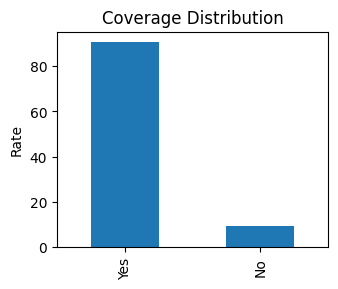

In [33]:
plt.figure(figsize=(3.5, 2.8))
(
df_enrollment['coverage_continuous_flag'].
    value_counts(normalize=True).
    mul(100).
    rename(index={1: 'Yes', 0: 'No'}).
    plot(kind='bar')
)
plt.xlabel("")
plt.ylabel("Rate")
plt.title("Coverage Distribution")
plt.show()

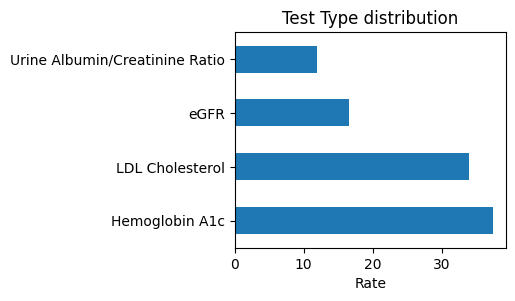

In [34]:
plt.figure(figsize=(3.5, 2.8))
(
df_labs['test_name'].
    value_counts(normalize=True).
    mul(100).
    plot(kind='barh')
)
plt.xlabel("Rate")
plt.ylabel("")
plt.title("Test Type distribution")
plt.show()


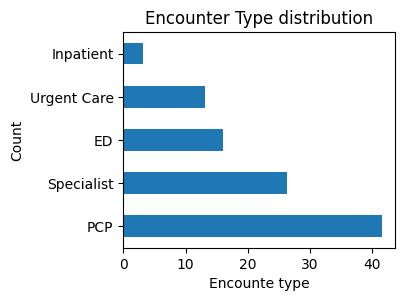

In [35]:
plt.figure(figsize=(3.5, 2.8))
(
df_claims_encounters['encounter_type'].
    value_counts(normalize=True).
    mul(100).
    plot(kind='barh')
)
plt.xlabel("Encounte type")
plt.ylabel("Count")
plt.title("Encounter Type distribution")
plt.show()


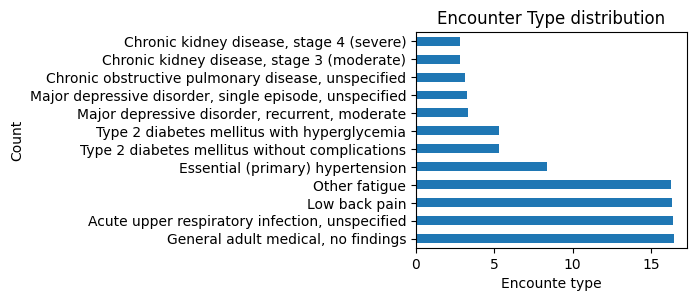

In [36]:
plt.figure(figsize=(3.5, 2.8))
(
df_claims_encounters['diagnosis_name'].
    value_counts(normalize=True).
    mul(100).
    plot(kind='barh')
)
plt.xlabel("Encounte type")
plt.ylabel("Count")
plt.title("Encounter Type distribution")
plt.show()



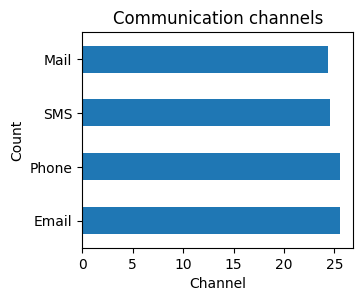

In [37]:
plt.figure(figsize=(3.5, 2.8))
(
df_outreach_contacts['channel'].
    value_counts(normalize=True).
    mul(100).
    plot(kind='barh')
)
plt.xlabel("Channel")
plt.ylabel("Count")
plt.title("Communication channels")
plt.show()


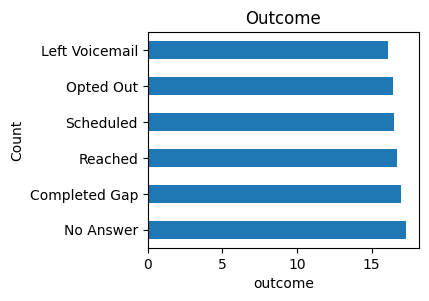

In [38]:
## Exploration data analysis - table per table (Provider level)
plt.figure(figsize=(3.5, 2.8))
(
df_outreach_contacts['outcome'].
    value_counts(normalize=True).
    mul(100).
    plot(kind='barh')
)
plt.xlabel("outcome")
plt.ylabel("Count")
plt.title("Outcome")
plt.show()


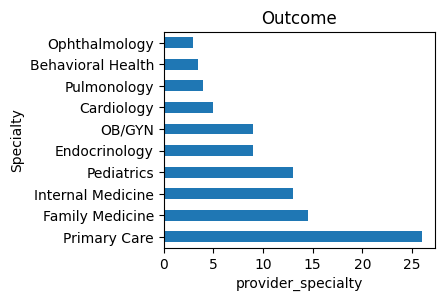

In [39]:
plt.figure(figsize=(3.5, 2.8))
(
df_providers['provider_specialty'].
    value_counts(normalize=True).
    mul(100).
    plot(kind='barh')
)
plt.xlabel("provider_specialty")
plt.ylabel("Specialty")
plt.title("Outcome")
plt.show()


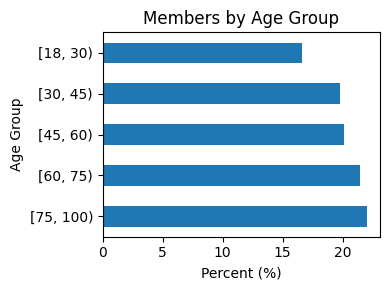

In [40]:
plt.figure(figsize=(4, 3))

(
    df_medicaid_members["age_group"]
    .cat.remove_unused_categories()   # 🔑 removes 0–18 cleanly
    .value_counts(normalize=True)
    .mul(100)
    .plot(kind="barh")
)

plt.xlabel("Percent (%)")
plt.ylabel("Age Group")
plt.title("Members by Age Group")
plt.tight_layout()
plt.show()


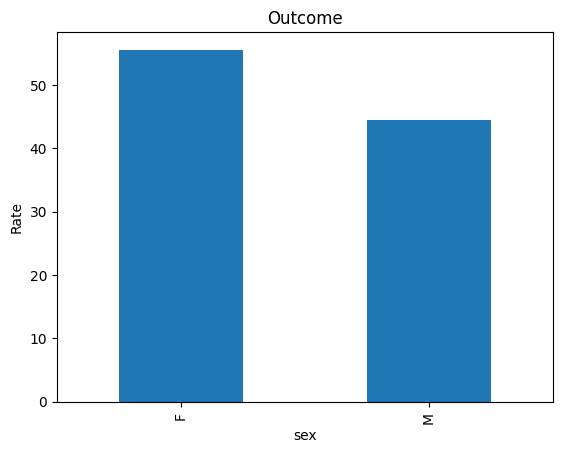

In [41]:
## ploting sex

df_medicaid_members['sex'].value_counts(normalize=True).mul(100).plot(kind='bar')
plt.xlabel("sex")
plt.ylabel("Rate")
plt.title("Outcome")
plt.show()


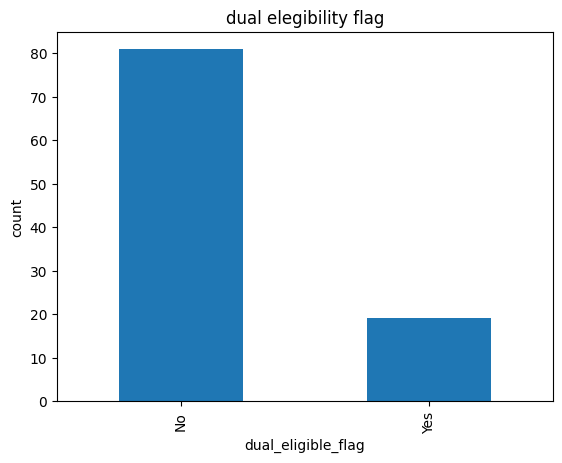

In [42]:
(
df_medicaid_members['dual_eligible_flag'].value_counts(normalize=True).
    rename(index={1: 'Yes', 0: 'No'}).mul(100).plot(kind='bar')
)
plt.xlabel("dual_eligible_flag")
plt.ylabel("count")
plt.title("dual elegibility flag")
plt.show()


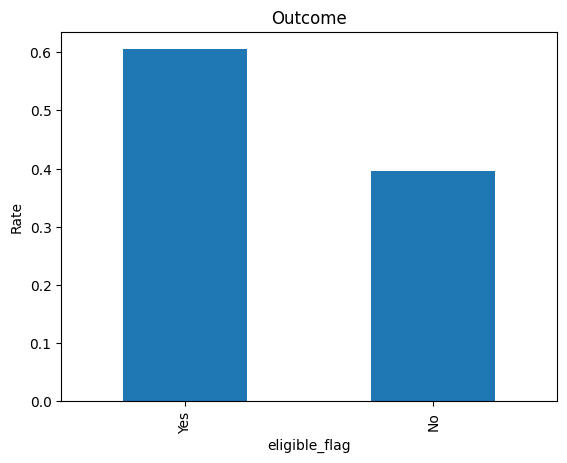

In [43]:
df_hedis_gaps['eligible_flag'].value_counts(normalize=True).rename(index={1: 'Yes', 0: 'No'}).plot(kind='bar')
plt.xlabel("eligible_flag")
plt.ylabel("Rate")
plt.title("Outcome")
plt.show()


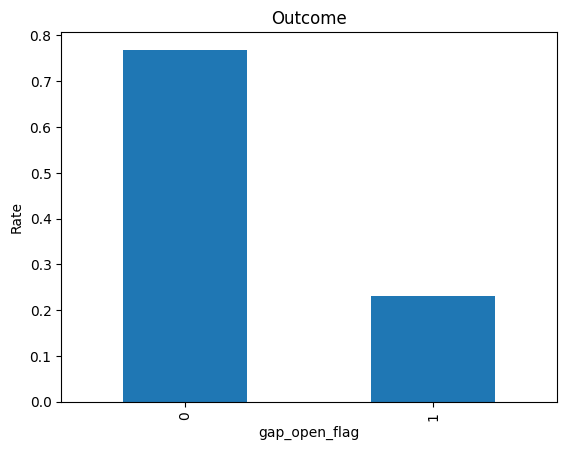

In [44]:
## ploting dual_eligible_flag


##

df_hedis_gaps['gap_open_flag'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel("gap_open_flag")
plt.ylabel("Rate")
plt.title("Outcome")
plt.show()



#### 6. Merging all the datasets in one: df_final

In [45]:
from functools import reduce

member_tables = [
    df_medicaid_members,
    df_members,
    df_enrollment
    
]

df_member_master = reduce(
    lambda l, r: pd.merge(l, r, on="member_id", how="left"),
    member_tables
)

claims_summary = (
    df_claims_encounters
    .groupby("member_id")
    .agg(
        n_encounters=("claim_id", "nunique"),
        total_paid=("paid_amount", "sum"),
        n_dx=("diagnosis_code", "nunique")
    )
    .reset_index()
)

encounter_type_counts = (
    pd.crosstab(
        df_claims_encounters["member_id"],
        df_claims_encounters["encounter_type"]
    )
    .add_prefix("enc_")
    .reset_index()
)


labs_summary = (
    df_labs
    .groupby("member_id")
    .agg(
        n_labs=("lab_id", "nunique"),
        test_labs=("test_name", "sum")
    )
    .reset_index()
)

pharmacy_summary = (
    df_pharmacy
    .groupby("member_id")
    .agg(
        n_rx=("rx_id", "nunique"),
        total_rx_cost=("paid_amount", "sum")
    )
    .reset_index()
)

# outreach

# pick the right date column name if you have it
date_col = "contact_date"  # change if yours is different

# make sure it's datetime
df_outreach_contacts[date_col] = pd.to_datetime(df_outreach_contacts[date_col], errors="coerce")

# 1) Most recent record per member (for channel/outcome)
outreach_latest = (
    df_outreach_contacts
    .sort_values([ "member_id", date_col ])
    .dropna(subset=["member_id"])
    .drop_duplicates("member_id", keep="last")[["member_id", "channel", "outcome", "attempt_number"]]
    .rename(columns={
        "channel": "last_outreach_channel",
        "outcome": "last_outreach_outcome",
        "attempt_number": "last_attempt_number"
    })
)

# 2) Aggregates per member
outreach_agg = (
    df_outreach_contacts
    .groupby("member_id", as_index=False)
    .agg(
        n_outreach=("contact_id", "count"),
        max_attempt_number=("attempt_number", "max")
    )
)

# 3) Combine to one summary table
outreach_summary = outreach_agg.merge(outreach_latest, on="member_id", how="left")

utilization_summary = df_utilization.copy()

hedis_summary = (
    df_hedis_gaps
    .groupby("member_id")
    .agg(
        open_gaps=("gap_open_flag", "sum"),
        measures=("measure_id", "nunique")
    )
    .reset_index()
)

condition_flags = [
    "diabetes_flag",
    "hypertension_flag",
    "copd_flag",
    "depression_flag",
    "ckd_flag",
    "obesity_flag"
]

conditions_summary = (
    df_conditions
    .groupby("member_id", as_index=False)[condition_flags]
    .max()  # safe even if duplicates; keeps 1 if any record shows the condition
)

conditions_summary["n_conditions"] = conditions_summary[condition_flags].sum(axis=1)


utilization_summary = df_utilization.copy()

hedis_summary = (
    df_hedis_gaps
    .groupby("member_id", as_index=False)
    .agg(
        open_gaps=("gap_open_flag", "sum"),
        measures=("measure_id", "nunique")
    )
    .assign(
        # Risk score (explainable, weighted)
        risk_score=lambda d: d["open_gaps"] * 2 + d["measures"],

        # Risk group
        risk_score_group=lambda d: pd.qcut(
            d["risk_score"],
            q=[0, 0.7, 0.9, 1.0],
            labels=["Low", "Medium", "High"]
        )
    )
)

## diagnosis: 

dx_top_summary = (
    df_claims_encounters
    .groupby(["member_id", "diagnosis_name"], as_index=False)
    .size()
    .sort_values(["member_id", "size"], ascending=[True, False])
    .drop_duplicates("member_id")
    .rename(columns={
        "diagnosis_name": "top_diagnosis",
        "size": "top_diagnosis_n"
    })
)



summary_tables = [
    claims_summary,
    encounter_type_counts,   # ← ADD HERE
    dx_top_summary,
    labs_summary,
    pharmacy_summary,
    outreach_summary,
    conditions_summary,
    utilization_summary,
    hedis_summary
]



df_final = reduce(
    lambda l, r: pd.merge(l, r, on="member_id", how="left"),
    [df_member_master] + summary_tables
)

df_final = df_final.merge(
    df_cdc_places,
    left_on="zip",
    right_on="zip",
    how="left"
)

print(df_final.shape)
print(df_final["member_id"].nunique())


(5000, 63)
5000


In [46]:
encounter_type_counts.columns


Index(['member_id', 'enc_ED', 'enc_Inpatient', 'enc_PCP', 'enc_Specialist',
       'enc_Urgent Care'],
      dtype='object', name='encounter_type')

In [47]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   member_id                      5000 non-null   int64   
 1   age                            5000 non-null   int64   
 2   sex                            5000 non-null   object  
 3   zip                            5000 non-null   int64   
 4   zip3                           5000 non-null   int64   
 5   plan_type                      5000 non-null   object  
 6   dual_eligible_flag             5000 non-null   int64   
 7   preferred_language             5000 non-null   object  
 8   has_pcp_flag                   5000 non-null   int64   
 9   enrollment_months              5000 non-null   int64   
 10  age_group                      5000 non-null   category
 11  pcp_provider_id                4117 non-null   float64 
 12  care_team_specialist_id        175

#### 7. bivariate analysis: 

In [48]:
## create cross tab functionality

## function for matrix
def crosstab_npct(df, row, col):
    n = pd.crosstab(df[row], df[col])
    p = n.div(n.sum(axis=1), axis=0).mul(100).round(1)
    return n.astype(str) + " (" + p.astype(str) + "%)"


In [49]:
crosstab_npct(df_final, "risk_score_group", "last_attempt_number")

last_attempt_number,1.0,2.0,3.0
risk_score_group,,,
Low,1630 (57.3%),847 (29.8%),367 (12.9%)
Medium,328 (57.0%),182 (31.7%),65 (11.3%)
High,167 (52.4%),99 (31.0%),53 (16.6%)


In [50]:
crosstab_npct(df_final, "risk_score_group", "sex")

sex,F,M
risk_score_group,,
Low,2164 (52.9%),1924 (47.1%)
Medium,384 (65.1%),206 (34.9%)
High,230 (71.4%),92 (28.6%)


Text(0, 0.5, 'Number of PCP encounters')

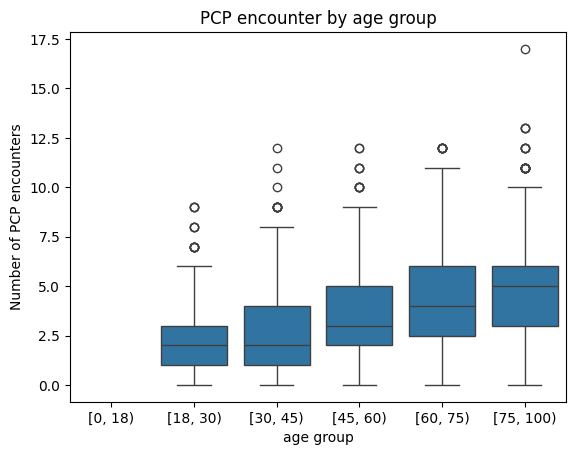

In [51]:
sns.boxplot(
    data=df_final,
    x="age_group",
    y="enc_PCP",
    )

plt.title("PCP encounter by age group")
plt.xlabel("age group")
plt.ylabel("Number of PCP encounters")



Text(0, 0.5, 'age')

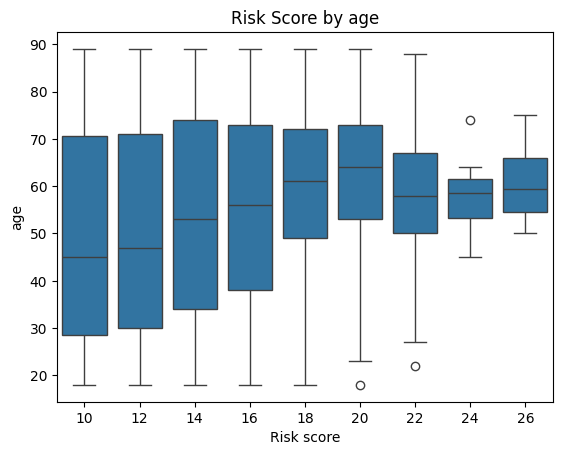

In [52]:
sns.boxplot(
    data=df_final,
    x="risk_score",
    y="age",
    )

plt.title("Risk Score by age")
plt.xlabel("Risk score")
plt.ylabel("age")



#### 8. Identifying non-completed gap population: 

In [53]:
outcomes_keep = [
    "Left Voicemail",
    "No Answer",
    "Opted Out",
    "Reached",
    "Scheduled"
]

df_population = df_final.loc[
    df_final["last_outreach_outcome"].isin(outcomes_keep)
].copy()


In [54]:
## there is any difference 

import numpy as np

df_population["reach_status"] = np.where(
    df_population["last_outreach_outcome"].isin(["Reached", "Scheduled"]),
    "Reached",
    "Not Reached"
)

reach_by_channel = pd.crosstab(
    df_population["last_outreach_channel"],
    df_population["reach_status"]
)

reach_by_channel


reach_status,Not Reached,Reached
last_outreach_channel,,
Email,491,303
Mail,444,292
Phone,474,336
SMS,456,304


In [55]:
reach_by_channel_pct = (
    reach_by_channel
    .div(reach_by_channel.sum(axis=1), axis=0)
    .mul(100)
    .round(1)
)

reach_by_channel_pct


reach_status,Not Reached,Reached
last_outreach_channel,,
Email,61.8,38.2
Mail,60.3,39.7
Phone,58.5,41.5
SMS,60.0,40.0


In [56]:
reach_summary = reach_by_channel.copy()

reach_summary["Reached_%"] = reach_by_channel_pct["Reached"]
reach_summary["Not_Reached_%"] = reach_by_channel_pct["Not Reached"]

reach_summary


reach_status,Not Reached,Reached,Reached_%,Not_Reached_%
last_outreach_channel,,,,
Email,491,303,38.2,61.8
Mail,444,292,39.7,60.3
Phone,474,336,41.5,58.5
SMS,456,304,40.0,60.0


In [57]:
reach_long = (
    df_population
    .groupby(["last_outreach_channel", "reach_status"])
    .size()
    .reset_index(name="N")
)

reach_long["Percent"] = (
    reach_long
    .groupby("last_outreach_channel")["N"]
    .transform(lambda x: (x / x.sum() * 100).round(1))
)

reach_long


,last_outreach_channel,reach_status,N,Percent
0,Email,Not Reached,491,61.8
1,Email,Reached,303,38.2
2,Mail,Not Reached,444,60.3
3,Mail,Reached,292,39.7
4,Phone,Not Reached,474,58.5
5,Phone,Reached,336,41.5
6,SMS,Not Reached,456,60.0
7,SMS,Reached,304,40.0


In [58]:
pd.crosstab(
    [df_population["last_outreach_channel"], df_population["risk_score_group"]],
    df_population["reach_status"],
    normalize="index"
).mul(100).round(1)


reach_status                            Not Reached  Reached
last_outreach_channel risk_score_group                      
Email                 Low                      61.8     38.2
                      Medium                   67.0     33.0
                      High                     54.7     45.3
Mail                  Low                      61.2     38.8
                      Medium                   54.9     45.1
                      High                     61.3     38.7
Phone                 Low                      59.1     40.9
                      Medium                   55.6     44.4
                      High                     59.7     40.3
SMS                   Low                      59.1     40.9
                      Medium                   63.6     36.4
                      High                     60.6     39.4

In [59]:
## create cross tab functionality

## function for matrix
def crosstab_npct(df, row, col):
    n = pd.crosstab(df[row], df[col])
    p = n.div(n.sum(axis=1), axis=0).mul(100).round(1)
    return n.astype(str) + " (" + p.astype(str) + "%)"

crosstab_npct(df_population, "top_diagnosis", "reach_status",)

reach_status,Not Reached,Reached
top_diagnosis,,
"Acute upper respiratory infection, unspecified",535 (61.5%),335 (38.5%)
"Chronic kidney disease, stage 3 (moderate)",57 (64.0%),32 (36.0%)
"Chronic kidney disease, stage 4 (severe)",45 (54.2%),38 (45.8%)
"Chronic obstructive pulmonary disease, unspecified",56 (63.6%),32 (36.4%)
Essential (primary) hypertension,150 (60.5%),98 (39.5%)
"General adult medical, no findings",337 (60.6%),219 (39.4%)
Low back pain,268 (58.4%),191 (41.6%)
"Major depressive disorder, recurrent, moderate",34 (54.8%),28 (45.2%)
"Major depressive disorder, single episode, unspecified",26 (46.4%),30 (53.6%)


In [60]:
crosstab_npct(df_population, "top_diagnosis_n", "reach_status",)

reach_status,Not Reached,Reached
top_diagnosis_n,,
1.0,189 (65.2%),101 (34.8%)
2.0,445 (58.0%),322 (42.0%)
3.0,585 (59.1%),405 (40.9%)
4.0,401 (62.0%),246 (38.0%)
5.0,163 (57.6%),120 (42.4%)
6.0,52 (66.7%),26 (33.3%)
7.0,13 (65.0%),7 (35.0%)
8.0,0 (0.0%),2 (100.0%)
9.0,0 (0.0%),1 (100.0%)


In [61]:
crosstab_npct(df_population, "open_gaps", "reach_status",)

reach_status,Not Reached,Reached
open_gaps,,
1,318 (63.7%),181 (36.3%)
2,595 (58.7%),418 (41.3%)
3,502 (60.2%),332 (39.8%)
4,291 (60.1%),193 (39.9%)
5,114 (55.6%),91 (44.4%)
6,31 (67.4%),15 (32.6%)
7,12 (75.0%),4 (25.0%)
8,2 (66.7%),1 (33.3%)


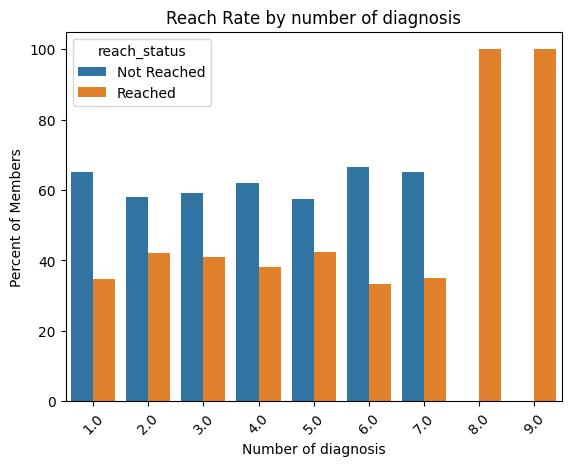

In [62]:
reach_pct = (
    df_population
    .groupby(["top_diagnosis_n", "reach_status"])
    .size()
    .reset_index(name="N")
)

reach_pct["Percent"] = (
    reach_pct
    .groupby("top_diagnosis_n")["N"]
    .transform(lambda x: x / x.sum() * 100)
)

sns.barplot(
    data=reach_pct,
    x="top_diagnosis_n",
    y="Percent",
    hue="reach_status"
)

plt.ylabel("Percent of Members")
plt.xlabel("Number of diagnosis")
plt.title("Reach Rate by number of diagnosis")
plt.xticks(rotation=45)
plt.show()


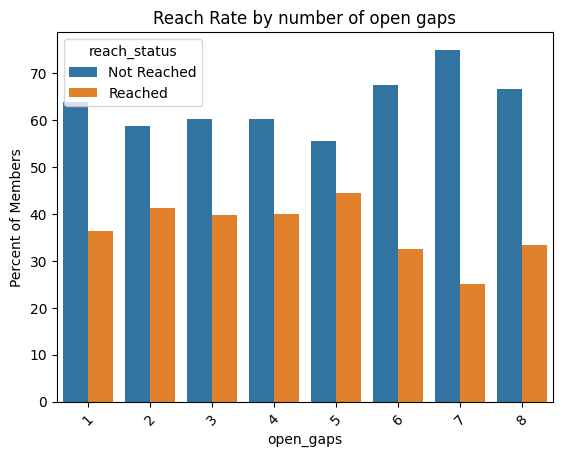

In [63]:
reach_pct = (
    df_population
    .groupby(["open_gaps", "reach_status"])
    .size()
    .reset_index(name="N")
)

reach_pct["Percent"] = (
    reach_pct
    .groupby("open_gaps")["N"]
    .transform(lambda x: x / x.sum() * 100)
)

sns.barplot(
    data=reach_pct,
    x="open_gaps",
    y="Percent",
    hue="reach_status"
)

plt.ylabel("Percent of Members")
plt.xlabel("open_gaps")
plt.title("Reach Rate by number of open gaps")
plt.xticks(rotation=45)
plt.show()


Text(0, 0.5, 'Diagnosis ICD-10')

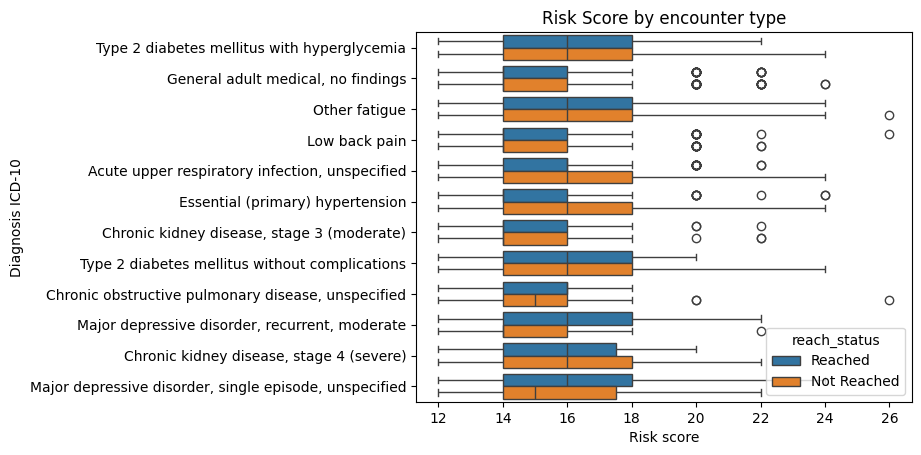

In [64]:
sns.boxplot(
    data=df_population,
    x="risk_score",
    y="top_diagnosis",
    hue='reach_status'
    )

plt.title("Risk Score by encounter type")
plt.xlabel("Risk score")
plt.ylabel("Diagnosis ICD-10")


#### 9. CDC and HEDIS analysis: statistical tests (t-test & chi-square)

In [65]:
## CDC and HEDIS

df_final["reach_status"] = np.where(
    df_final["last_outreach_outcome"].isin(["Reached", "Scheduled"]),
    "Reached",
    "Not Reached"
)

cdc_vars = [
    "poverty_rate",
    "education_lte_highschool_rate",
    "language_isolation_rate",
    "broadband_access_rate",
    "no_routine_checkup_rate",
    "cost_barrier_care_rate",
    "diabetes_prevalence",
    "hypertension_prevalence",
    "smoking_prevalence",
    "physical_inactivity_rate"
]

cdc_table = (
    df_final
    .groupby("reach_status")[cdc_vars]
    .mean()
    .round(2)
    .reset_index()
)

cdc_table["N"] = cdc_table["reach_status"].map(cdc_counts)
cdc_table



NameError: name 'cdc_counts' is not defined

In [ ]:
diff = (
    cdc_table
    .set_index("reach_status")
    .diff()
    .loc["Not Reached"]
    .rename("Not_Reached_minus_Reached")
)

diff


In [ ]:
from scipy.stats import ttest_ind

ttest_results = []

for var in cdc_vars:
    r = df_final[df_final["reach_status"] == "Reached"][var].dropna()
    nr = df_final[df_final["reach_status"] == "Not Reached"][var].dropna()
    
    stat, p = ttest_ind(r, nr, equal_var=False)
    
    ttest_results.append({
        "variable": var,
        "Reached_mean": r.mean(),
        "Not_Reached_mean": nr.mean(),
        "p_value": round(p, 4)
    })

ttest_df = pd.DataFrame(ttest_results)
ttest_df


In [ ]:
### chi square comparing between two groups and language

language_table = pd.crosstab(
    df_final["reach_status"],
    df_final["preferred_language"]
)

language_table

from scipy.stats import chi2_contingency

chi2, p_value, dof, expected = chi2_contingency(language_table)

chi2, p_value

alpha = 0.05

if p_value < alpha:
    print("There IS a statistically significant difference in language distribution between Reached and Not Reached groups.")
else:
    print("There is NO statistically significant difference in language distribution between Reached and Not Reached groups.")

language_pct = (
    language_table
    .div(language_table.sum(axis=1), axis=0)
    .mul(100)
    .round(1)
)

language_pct


In [ ]:
import numpy as np

n = language_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(language_table.shape) - 1)))

cramers_v

## small effect 




In [ ]:
from scipy.stats import ttest_ind

# Split groups
reached = df_final.loc[
    df_final["reach_status"] == "Reached",
    "language_isolation_rate"
].dropna()

not_reached = df_final.loc[
    df_final["reach_status"] == "Not Reached",
    "language_isolation_rate"
].dropna()

t_stat, p_value = ttest_ind(
    reached,
    not_reached,
    equal_var=False
)

t_stat, p_value

summary = pd.DataFrame({
    "Group": ["Reached", "Not Reached"],
    "N": [reached.shape[0], not_reached.shape[0]],
    "Mean (%)": [reached.mean(), not_reached.mean()],
    "Std Dev": [reached.std(), not_reached.std()]
}).round(2)

summary

alpha = 0.05

if p_value < alpha:
    print("Statistically significant difference in language isolation rates between groups.")
else:
    print("No statistically significant difference in language isolation rates between groups.")
